# Siamese Network (샴 네트워크)

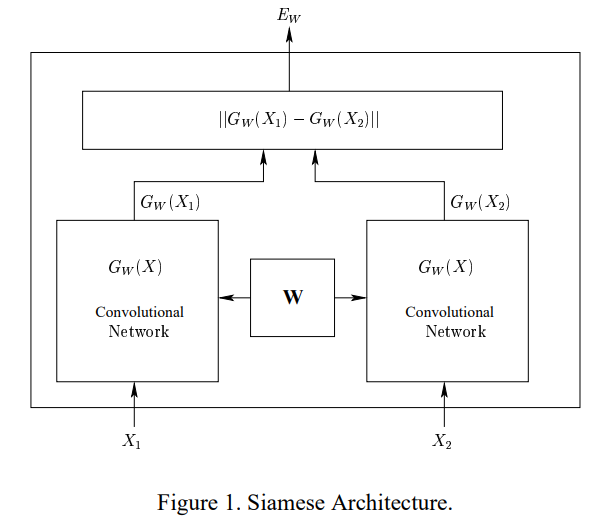 

- 2개의 Input을 가지고 같은 네트워크를 통해서 Output Vector가 추출되는 구조를 가지고 있습니다.
- Vector들은 서로 비교를 통해 두 입력의 유사도를 측정할 수 있습니다.

> Siamese Network는 얼굴 인식에서 One-shot learning을 위해 자주 사용됩니다.


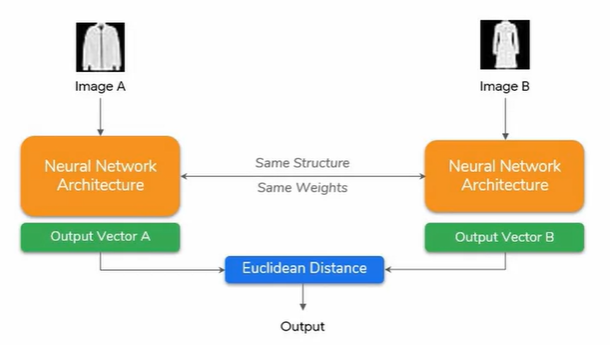 
> Siamese Network를 사용해서 위와 같은 Fashion MNIST data를 쌍으로 비교하는 모델을 구성해보겠습니다. <br>
신경망을 통해 출력된 벡터는 유클리드 거리를 통해 유사도 측정이 됩니다.


In [1]:
from tensorflow.keras.datasets import fashion_mnist
import random
import numpy as np

# 데이터 불러오기
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

# 정규화
train_images = train_images / 255.
test_images = test_images / 255.

In [2]:
# create pairs on train and test sets
def create_pairs(x, y):
    pairs = []
    labels = []
    
    
    digit_indices = [np.where(y == i)[0] for i in range(10)]    
    n = min([len(digit_indices[d]) for d in range(10)]) - 1
    

    for d in range(10):
        for i in range(n):
            z1, z2 = digit_indices[d][i], digit_indices[d][i+1]
            pairs += [[x[z1], x[z2]]]
            inc = random.randrange(1, 10)
            dn = (d + inc) % 10
            z1, z2 = digit_indices[d][i], digit_indices[dn][i]
            pairs += [[x[z1], x[z2]]]
            labels += [1, 0]
    return np.array(pairs), np.array(labels).astype('float32')


tr_pairs, tr_y = create_pairs(train_images, train_labels)
ts_pairs, ts_y = create_pairs(test_images, test_labels)

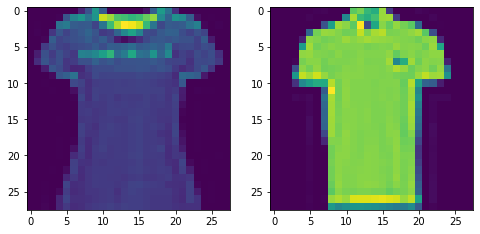

In [3]:
import matplotlib.pyplot as plt

def show_image(image1, image2):
    plt.figure(figsize=(8, 4))
    plt.grid(False)
    
    plt.subplot(1,2,1)
    plt.imshow(image1)
    
    plt.subplot(1,2,2)
    plt.imshow(image2)
    
    plt.show()

this_pair = 8
# show images at this index
show_image(ts_pairs[this_pair][0], ts_pairs[this_pair][1])

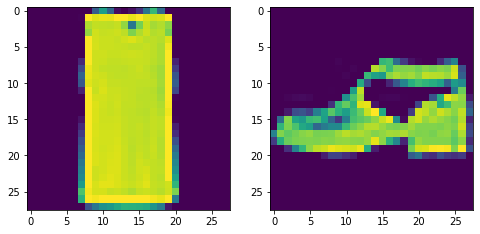

In [4]:
show_image(ts_pairs[3][0], ts_pairs[3][1])

## Output Vector의 기본 베이스 모델과 유클리드 거리 함수

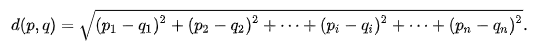 
> 유클리드 거리 함수 공식

In [5]:
from tensorflow.keras.layers import Flatten

def base_network():
    input = Input(shape=(28, 28), name='base_input')
    x = Flatten(name='flatten_input')(input)
    x = Dense(128, activation='relu', name='first_base_dense')(x)
    x = Dropout(0.1, name='first_dropout')(x)
    x = Dense(128, activation='relu', name='second_base_dense')(x)
    x = Dropout(0.1, name='second_dropout')(x)
    x = Dense(128, activation='relu', name='third_base_dense')(x)
    
    return Model(inputs=input, outputs=x)

def euclidean_distance(vects):
    x, y = vects
    sum_square = tf.math.reduce_sum(tf.math.square(x - y), axis=1, keepdims=True)
    return tf.math.sqrt(tf.math.maximum(sum_square, 1e-7))

## Base Model

In [6]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Dropout

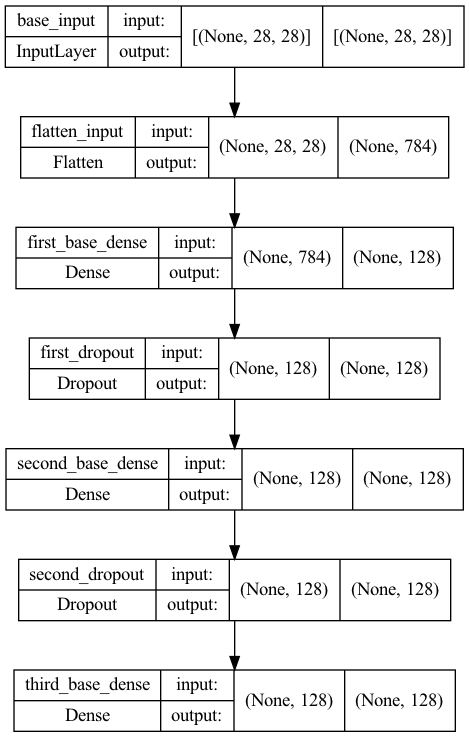

In [9]:
from tensorflow.keras.utils import plot_model
base_model = base_network()
plot_model(base_model, show_shapes=True, show_layer_names=True)

## Siamese Network

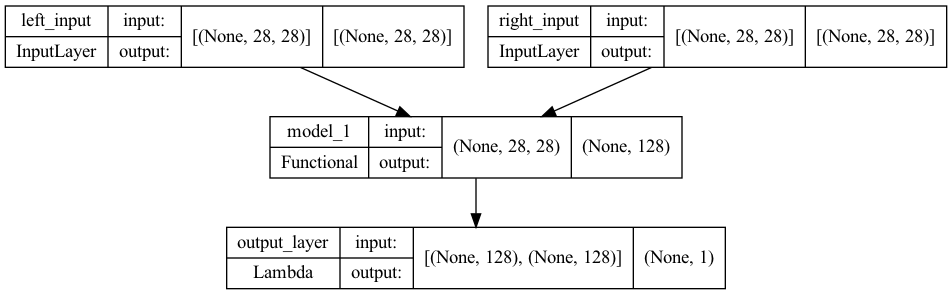

In [11]:
from tensorflow.keras.layers import Lambda
import tensorflow as tf


input_a = Input(shape=(28,28,), name='left_input')
vector_output_a = base_model(input_a)
input_b = Input(shape=(28,28,), name='right_input')
vector_output_b = base_model(input_b)
output = Lambda(euclidean_distance, name='output_layer')([vector_output_a, vector_output_b])

# define model
model = Model([input_a, input_b], output)
plot_model(model, show_shapes=True, show_layer_names=True)

## Left, Right 둘 다 동일한 네트워크를 통과하는 중.
> Compile은 custom loss 를 사용 / 사용되는 loss는 contrastive loss이며 아래의 그림과 같이 계산됩니다.
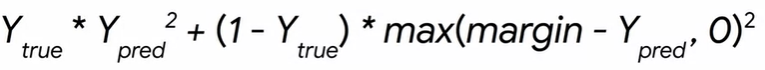

In [14]:
from tensorflow.keras.optimizers import RMSprop
def contrastive_loss_with_margin(margin):
    def contrastive_loss(y_true, y_pred):
        square_pred = tf.math.square(y_pred)
        margin_square = tf.math.square(tf.math.maximum(margin - y_pred, 0))
        return tf.math.reduce_mean(y_true * square_pred + (1 - y_true) * margin_square)
    
    return contrastive_loss


rms = RMSprop()
model.compile(loss=contrastive_loss_with_margin(margin=1), optimizer=rms)
history = model.fit([tr_pairs[:,0], tr_pairs[:,1]], tr_y, epochs=20, batch_size=128, validation_data=([ts_pairs[:,0], ts_pairs[:,1]], ts_y))

Epoch 1/20
938/938 [==============================] - 7s 5ms/step - loss: 0.0471 - val_loss: 0.0657
Epoch 2/20
938/938 [==============================] - 5s 5ms/step - loss: 0.0467 - val_loss: 0.0664
Epoch 3/20
938/938 [==============================] - 5s 5ms/step - loss: 0.0464 - val_loss: 0.0673
Epoch 4/20
938/938 [==============================] - 5s 5ms/step - loss: 0.0463 - val_loss: 0.0680
Epoch 5/20
938/938 [==============================] - 5s 5ms/step - loss: 0.0461 - val_loss: 0.0687
Epoch 6/20
938/938 [==============================] - 5s 5ms/step - loss: 0.0459 - val_loss: 0.0660
Epoch 7/20
938/938 [==============================] - 5s 5ms/step - loss: 0.0461 - val_loss: 0.0665
Epoch 8/20
938/938 [==============================] - 5s 5ms/step - loss: 0.0457 - val_loss: 0.0645
Epoch 9/20
938/938 [==============================] - 5s 5ms/step - loss: 0.0456 - val_loss: 0.0665
Epoch 10/20
938/938 [==============================] - 5s 5ms/step - loss: 0.0457 - val_loss: 0.0667

In [15]:
def compute_accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    pred = y_pred.ravel() < 0.5
    return np.mean(pred == y_true)

loss = model.evaluate([ts_pairs[:,0],ts_pairs[:,1]], ts_y)

y_pred_train = model.predict([tr_pairs[:,0], tr_pairs[:,1]])
train_accuracy = compute_accuracy(tr_y, y_pred_train)

y_pred_test = model.predict([ts_pairs[:,0], ts_pairs[:,1]])
test_accuracy = compute_accuracy(ts_y, y_pred_test)

print("Loss = {}, Train Accuracy = {} Test Accuracy = {}".format(loss, train_accuracy, test_accuracy))

625/625 [==============================] - 1s 2ms/step - loss: 0.0669
Loss = 0.06694722175598145, Train Accuracy = 0.9542590431738623 Test Accuracy = 0.9118118118118118


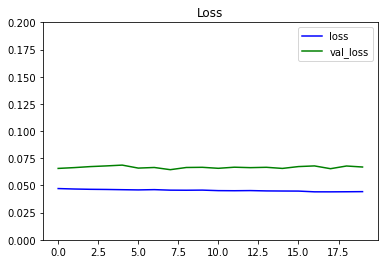

In [16]:
def plot_metrics(metric_name, title, ylim=5):
    plt.title(title)
    plt.ylim(0,ylim)
    plt.plot(history.history[metric_name],color='blue',label=metric_name)
    plt.plot(history.history['val_' + metric_name],color='green',label='val_' + metric_name)
    plt.legend()
    
plot_metrics(metric_name='loss', title="Loss", ylim=0.2)

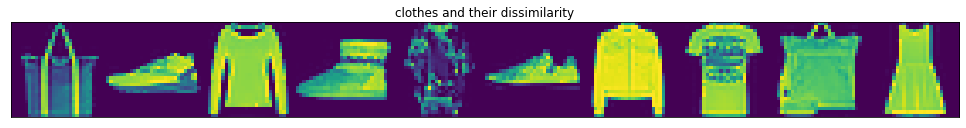

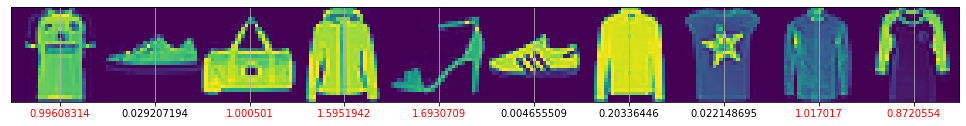

In [17]:
def display_images(left, right, predictions, labels, title, n):
    plt.figure(figsize=(17,3))
    plt.title(title)
    plt.yticks([])
    plt.xticks([])
    plt.grid(None)
    left = np.reshape(left, [n, 28, 28])
    left = np.swapaxes(left, 0, 1)
    left = np.reshape(left, [28, 28*n])
    plt.imshow(left)
    plt.figure(figsize=(17,3))
    plt.yticks([])
    plt.xticks([28*x+14 for x in range(n)], predictions)
    for i,t in enumerate(plt.gca().xaxis.get_ticklabels()):
        if predictions[i] > 0.5: t.set_color('red') # bad predictions in red
    plt.grid(None)
    right = np.reshape(right, [n, 28, 28])
    right = np.swapaxes(right, 0, 1)
    right = np.reshape(right, [28, 28*n])
    plt.imshow(right)


y_pred_train = np.squeeze(y_pred_train)
indexes = np.random.choice(len(y_pred_train), size=10)
display_images(tr_pairs[:, 0][indexes], tr_pairs[:, 1][indexes], y_pred_train[indexes], tr_y[indexes], "clothes and their dissimilarity", 10)